In [9]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import holidays
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

sns.set()

random_state = 123_456
np.random.seed(random_state)

In [10]:
holiday_list = list()

# for date, name in holidays.AU(prov='NSW', years=[2016,2017,2018,2019,2020]).items():
for date, name in holidays.AU(prov='NSW', years=[2016,2017,2018,2019,2020]).items():
    holiday_list.append(dict(ds=date,holiday=name))
#     print(date, name)
    
df_holidays = pd.DataFrame(holiday_list)
df_holidays

ds                holiday
0   2016-01-01         New Year's Day
1   2016-01-26          Australia Day
2   2016-03-25            Good Friday
3   2016-03-26        Easter Saturday
4   2016-03-27          Easter Sunday
..         ...                    ...
60  2020-08-03           Bank Holiday
61  2020-10-05             Labour Day
62  2020-12-25          Christmas Day
63  2020-12-26             Boxing Day
64  2020-12-28  Boxing Day (Observed)

[65 rows x 2 columns]

In [11]:
# holidays.AU

In [12]:
# import sys
# !{sys.executable} -m pip install holidays

In [13]:
df = pd.read_csv('fuel-prices/all_features_combined.csv', index_col='date', dtype={'price': np.int32, 
                 'tapis_oil_price': np.int32, 'national_avg_price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.shape[0], freq='D'), inplace=True, verify_integrity=True)

In [14]:
features = ['price']

In [15]:
df = df[features].copy()
df['weekday'] = df.index.weekday
df = df.loc[df.index >= '2019-06-01']
df

price  weekday
2019-06-01   1553        5
2019-06-02   1561        6
2019-06-03   1599        0
2019-06-04   1581        1
2019-06-05   1584        2
...           ...      ...
2019-12-27   1608        4
2019-12-28   1589        5
2019-12-29   1579        6
2019-12-30   1602        0
2019-12-31   1609        1

[214 rows x 2 columns]

In [19]:
df.describe()

price     weekday
count   214.000000  214.000000
mean   1661.733645    3.000000
std      94.326469    2.016365
min    1497.000000    0.000000
25%    1587.250000    1.000000
50%    1649.000000    3.000000
75%    1729.750000    5.000000
max    1872.000000    6.000000

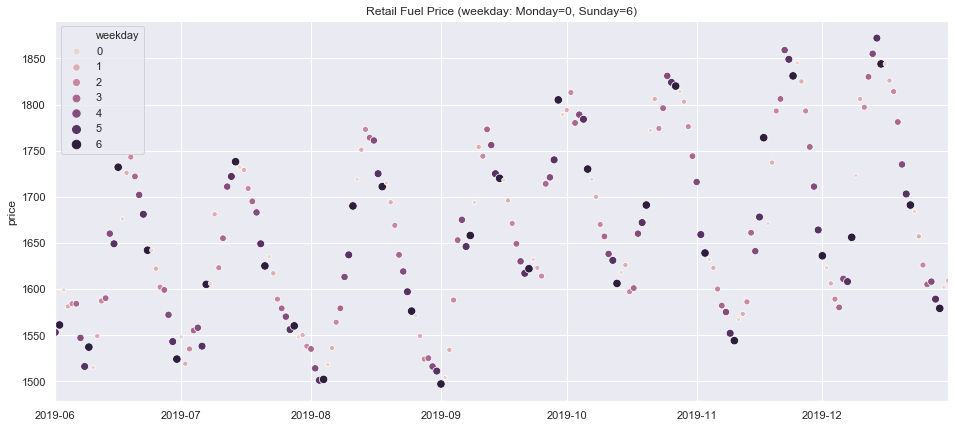

In [18]:
sns.set(rc={'figure.figsize':(16, 7)})
ax = sns.scatterplot(x=df.index, y='price', hue='weekday', size='weekday', data=df, legend='full')
ax.set_xlim(df.index.min(), df.index.max())
ax.set_title('Retail Fuel Price (weekday: Monday=0, Sunday=6)')
plt.show()

In [210]:
df_p = df[features].copy()
# df_p = df_p[(df_p.index >= '2019-02-01') & (df_p.index < '2019-10-01')]
df_p = df_p[(df_p.index >= '2017-02-01')]
df_p['ds'] = df_p.index
df_p.rename(columns={'price': 'y'}, inplace=True)
df_p.reset_index(inplace=True, drop=True)

In [211]:
df_p

y         ds
0     1403 2017-02-01
1     1433 2017-02-02
2     1409 2017-02-03
3     1386 2017-02-04
4     1401 2017-02-05
...    ...        ...
1059  1608 2019-12-27
1060  1589 2019-12-28
1061  1579 2019-12-29
1062  1602 2019-12-30
1063  1609 2019-12-31

[1064 rows x 2 columns]

In [212]:
cls = Prophet(daily_seasonality=False, holidays=df_holidays, changepoint_range=0.7)
# cls = Prophet(daily_seasonality=False, holidays=df_holidays)
# cls = Prophet(daily_seasonality=False, changepoint_range=0.9, changepoint_prior_scale=0.4, 
#               changepoints=['2018-11-01'], holidays=holidays, yearly_seasonality=20, holidays_prior_scale=0.05)
# cls.add_country_holidays(country_name='AU')
# print(cls.train_holiday_names)
# cls.add_seasonality(name='monthly', period=24, fourier_order=5)
p = cls.fit(df_p)

In [213]:
# help(cls)

In [214]:
df_f = cls.make_future_dataframe(periods=30)

In [215]:
# df_f

In [216]:
df_fc = cls.predict(df_f)

In [217]:
df_fc[df_fc.ds >= '2019-06-17'][-10:]

ds        trend   yhat_lower   yhat_upper  trend_lower  \
1084 2020-01-21  1721.629658  1570.011889  1747.727972  1719.811531   
1085 2020-01-22  1722.122269  1575.256272  1743.817012  1720.060292   
1086 2020-01-23  1722.614880  1572.769281  1745.159618  1720.401653   
1087 2020-01-24  1723.107492  1570.672767  1740.723165  1720.680759   
1088 2020-01-25  1723.600103  1555.362107  1726.257371  1720.937313   
1089 2020-01-26  1724.092714  1577.847148  1758.234547  1721.204305   
1090 2020-01-27  1724.585325  1656.796686  1827.253417  1721.445473   
1091 2020-01-28  1725.077937  1561.105914  1740.321625  1721.804238   
1092 2020-01-29  1725.570548  1556.839668  1734.670310  1722.082858   
1093 2020-01-30  1726.063159  1565.705915  1741.641182  1722.295401   

      trend_upper  Anzac Day  Anzac Day_lower  Anzac Day_upper  Australia Day  \
1084  1723.190360        0.0              0.0              0.0       0.000000   
1085  1723.949458        0.0              0.0              0.0       0.000000   
1086  1724.733820        0.0              0.0              0.0       0.000000   
1087  1725.517726        0.0              0.0              0.0       0.000000   
1088  1726.197444        0.0              0.0              0.0       0.000000   
1089  1726.889458        0.0              0.0              0.0      23.343596   
1090  1727.554185        0.0              0.0              0.0       0.000000   
1091  1728.308757        0.0              0.0              0.0       0.000000   
1092  1729.106748        0.0              0.0              0.0       0.000000   
1093  1729.907074        0.0              0.0              0.0       0.000000   

      ...    weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
1084  ...  0.746750      0.746750      0.746750 -63.312476    -63.312476   
1085  ...  0.340789      0.340789      0.340789 -65.271074    -65.271074   
1086  ...  5.512031      5.512031      5.512031 -67.385907    -67.385907   
1087  ...  2.034770      2.034770      2.034770 -69.581691    -69.581691   
1088  ... -5.134714     -5.134714     -5.134714 -71.778002    -71.778002   
1089  ... -3.755397     -3.755397     -3.755397 -73.891663    -73.891663   
1090  ...  0.255771      0.255771      0.255771 -75.839181    -75.839181   
1091  ...  0.746750      0.746750      0.746750 -77.539181    -77.539181   
1092  ...  0.340789      0.340789      0.340789 -78.914776    -78.914776   
1093  ...  5.512031      5.512031      5.512031 -79.895794    -79.895794   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
1084    -63.312476                   0.0                         0.0   
1085    -65.271074                   0.0                         0.0   
1086    -67.385907                   0.0                         0.0   
1087    -69.581691                   0.0                         0.0   
1088    -71.778002                   0.0                         0.0   
1089    -73.891663                   0.0                         0.0   
1090    -75.839181                   0.0                         0.0   
1091    -77.539181                   0.0                         0.0   
1092    -78.914776                   0.0                         0.0   
1093    -79.895794                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
1084                         0.0  1659.063932  
1085                         0.0  1657.191985  
1086                         0.0  1660.741004  
1087                         0.0  1655.560571  
1088                         0.0  1646.687387  
1089                         0.0  1669.789249  
1090                         0.0  1745.486724  
1091                         0.0  1648.285506  
1092                         0.0  1646.996561  
1093                         0.0  1651.679396  

[10 rows x 70 columns]

In [218]:
sns.set(rc={'figure.figsize':(16, 7)})
fig = cls.plot(df_fc)
a = add_changepoints_to_plot(fig.gca(), cls, df_fc)

In [199]:
# df_hat = df_fc[['ds','yhat']].copy()
# df_hat.set_index('ds', inplace=True)
# df_hat.rename(columns={'yhat': 'y_hat'}, inplace=True)
# df_hat.y_hat = df_hat.y_hat.apply(lambda x: round(x))
# df_hat.y_hat = df_hat.y_hat.astype('int')
# df_hat[-8:]

In [200]:
# df[-8:]

In [201]:
fig2 = cls.plot_components(df_fc)

In [75]:
1095-8

1087

In [67]:
df_cv = cross_validation(cls, initial='1042 days', period='4 days', horizon = '8 days')

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-11-10 00:00:00 and 2019-12-16 00:00:00


In [68]:
# df_cv

In [69]:
# df[1075:1095]

In [70]:
df_perf = performance_metrics(df_cv)

In [71]:
df_perf

horizon           mse        rmse         mae      mape     mdape  coverage
0  1 days  15468.830558  124.373753  111.796148  0.063979  0.062225       0.3
1  2 days  18582.834550  136.318871  122.865004  0.069577  0.067538       0.2
2  3 days  20338.908381  142.614545  122.694693  0.069388  0.073777       0.2
3  4 days  20310.766163  142.515845  124.981252  0.070860  0.075272       0.4
4  5 days  22004.293682  148.338443  130.152605  0.074082  0.084319       0.3
5  6 days  24568.990033  156.744984  142.378571  0.080478  0.072676       0.2
6  7 days  25777.551351  160.553889  143.403427  0.081174  0.076138       0.2
7  8 days  24179.735105  155.498344  129.416162  0.072940  0.071584       0.3

In [73]:
df_perf.mape[:4].mean()

0.06845102519130555

In [44]:
# df_m = df.merge(df_hat, how='left', left_index=True, right_index=True, validate='one_to_one')

In [45]:
# df_m['dif'] = df_m.price - df_m.y_hat
# df_m['aa'] = df_m.dif / df_m.price
# df_m['bb'] = df_m.aa.abs()
# df_m.bb.mean() * 100

In [59]:
# def mean_absolute_percentage_error(y_true, y_pred): 
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [63]:
# def get_relative_accuracy(y_test, y_hat, tolerance_percentage):
#     it = np.nditer(y_test, flags=['f_index'])
#     non_error_count = 0
    
#     while not it.finished:
#         upper_limit = it[0] * (1 + tolerance_percentage / 100)
#         lower_limit = it[0] - (upper_limit - it[0])
#         non_error_count += 1 if y_hat[it.index] < upper_limit and y_hat[it.index] > lower_limit else 0
#         it.iternext()
        
#     return non_error_count / y_test.size

In [76]:
# error_tolerance_percentage = 3

In [79]:
# 100-mean_absolute_percentage_error(df_m.price[-7:], df_m.y_hat[-7:])

96.13445694649164

In [78]:
# get_relative_accuracy(df_m.price[-7:], df_m.y_hat[-7:], error_tolerance_percentage)

0.14285714285714285